In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import gc


### Big Data Import

import with minimal datatypes, and only desired columns (leave out attributed time in the training set)

In [3]:
train_cols = ['ip','app','device','os','channel','click_time','is_attributed']
test_cols = ['ip','app','device','os','channel','click_time','click_id']

dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'click_id'      : 'uint32',
        'is_attributed' : 'uint8'
        }
original_df = pd.read_csv('train.csv', usecols= train_cols, dtype = dtypes)

In [4]:
original_df.shape

(26877324, 7)

In [7]:
train_sample = pd.read_csv('train_sample.csv', usecols= train_cols, dtype = dtypes)

As we saw in the EDA, our labels are imbalanced. To create a better training dataset, we will take all of the 1's from the original dataframe, and all of the 0's from the sample dataframe given to us (to keep a random distributioin of the 0's)

In [9]:
original_df_minority = original_df[original_df['is_attributed'] == 1]
original_df_majority = original_df[original_df['is_attributed'] == 0]


In [13]:
del original_df
gc.collect()

407

In [15]:
train_samp_majority = train_sample[train_sample['is_attributed'] == 0]
len(train_samp_majority)
del train_sample
gc.collect()

40

In [14]:
balanced_df = pd.concat([original_df_minority, train_samp_majority])


Text(0.5, 0, 'Downloaded')

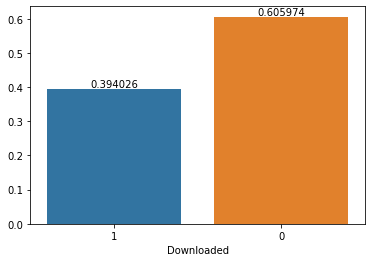

In [16]:
mean = (balanced_df.is_attributed.values==1).mean()
ax = sns.barplot(x =['1', '0'], y =[mean, 1-mean])
ax.bar_label(ax.containers[0]);
plt.xlabel('Downloaded')

In [17]:
#Split our balanced_df into X and y
X_balanced = balanced_df.iloc[:, :-1]
y_balanced = balanced_df.iloc[:, -1]

### Feature Engineering

To create meaningful features out of datetime given to us, we will split them up into day, hour, minutes, and seconds 

###### (the days should be converted from numbers to weekdays-- haven't done this yet)

Then, we create a series of groupby's and merges to attempt to create more meaningful features.

In [18]:
def pre_process(X): 
    X.click_time = pd.to_datetime(X.click_time, dayfirst = True)
    # d = X.set_index('click_time')
    X['day'] = X['click_time'].dt.day.astype('uint8')
    X['hour'] = X['click_time'].dt.hour.astype('uint8')
    X['min'] = X['click_time'].dt.minute.astype('uint8')
    X['sec'] = X['click_time'].dt.second.astype('uint8')

    gb = X.groupby(['ip','day', 'hour'])[['channel']].count().reset_index().rename(index = str, columns= {'channel' : 'ip_day_hour_count'})
    df = X.merge(gb, on=['ip','day','hour'], how='left' )

    del gb
    gc.collect()

    gb = X.groupby(['ip','app', 'os'])[['channel']].count().reset_index().rename(index = str, columns= {'channel' : 'ip_app_os_count'})
    df = df.merge(gb, on=['ip','app','os'], how='left' )

    del gb
    gc.collect()

    gb = X.groupby(['ip','app', 'device'])[['channel']].count().reset_index().rename(index = str, columns= {'channel' : 'ip_app_device_count'})
    df = df.merge(gb, on=['ip','app','device'], how='left' )

    del gb
    gc.collect()
    gb = X.groupby(['ip','channel', 'device'])[['app']].count().reset_index().rename(index = str, columns= {'app' : 'ip_channel_device_count'})
    df = df.merge(gb, on=['ip','channel','device'], how='left' )

    del gb
    gc.collect()
    gb = X.groupby(['ip','channel', 'os'])[['app']].count().reset_index().rename(index = str, columns= {'app' : 'ip_channel_os_count'})
    df = df.merge(gb, on=['ip','channel', 'os'], how='left' )
    return df

In [19]:
train_df = pre_process(X_balanced)

We need to drop click_time, as it is date time. 

Should also consider dropping IP, because it will be mistaken as continuos data (haven't done this yet)

In [20]:
train_df.drop(['click_time'], axis = 1, inplace =True)

In [16]:
train_df.head()

,ip,app,device,os,channel,day,hour,min,sec,ip_day_hour_count,ip_app_os_count,ip_app_device_count,ip_channel_device_count,ip_channel_os_count
0,204158,35,1,13,21,6,15,41,7,1,1,1,1,1
1,29692,9,1,22,215,6,16,0,2,1,1,1,1,1
2,64516,35,1,13,21,6,16,0,2,3,1,2,2,1
3,172429,35,1,46,274,6,16,0,3,1,1,1,1,1
4,199085,35,1,13,274,6,16,0,4,1,1,1,1,1


### Modeling

In [22]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(train_df, y_balanced, train_size= 0.7)


In [29]:
del train_df
gc.collect()

415

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
rf = RandomForestClassifier(oob_score= True)
rf.fit(x_train, y_train)
print(classification_report(y_val, rf.predict(x_val)))

C:\Users\sfrie\anaconda3\envs\py4dp\lib\site-packages\sklearn\base.py:442: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


              precision    recall  f1-score   support

           0       0.96      0.97      0.96     29999
           1       0.95      0.94      0.94     19396

    accuracy                           0.96     49395
   macro avg       0.96      0.95      0.95     49395
weighted avg       0.96      0.96      0.96     49395



In [24]:
rf.oob_score_

0.957207558956739

In [32]:
from sklearn.metrics import roc_auc_score 
roc_auc_score(y_val, rf.predict(x_val))

0.9535177165904156

### Export Predictions

In [26]:
test_df = pd.read_csv('test.csv') 
test_x = pre_process(test_df)
test_x.drop(['click_id', 'click_time'], axis = 1, inplace =True)

In [27]:
test_pred = rf.predict(test_x)

In [28]:
Id = test_df['click_id']

In [30]:
del test_df
gc.collect()

134

In [197]:
sub = pd.DataFrame({'Id': np.array(Id), 'Expected': test_pred})
# sub.columns = ['Id', 'Expected']
sub.Id = sub.Id.astype('Int64')
# sub.set_index('Id',inplace= True)

In [198]:
sub

,Id,Expected
0,2010044773365,0
1,2010044773366,0
2,2010044773367,0
3,2010044773368,0
4,2010044773369,0
...,...,...
3026553,2542620653135,0
3026554,2542620653136,0
3026555,2542620653137,0
3026556,2542620653138,0


In [199]:
pd.DataFrame.to_csv(sub, 'submission', index = False)